In [1]:
import numpy as np
import torch
from connectivity_representation_learning import *

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### Generate 2D Gaussian mixture data

In [2]:
# dimension
d = 256
# number of Gaussians in the mixture
K = 3
# number of points per cluster
N = 500

# for plotting
cmap = plt.get_cmap('gist_rainbow')
cNorm  = mpl.colors.Normalize(vmin=0, vmax=K)
scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmap)
colors = scalarMap.to_rgba(range(K))

data = []
labels = []
# random centroids in [-5,5]x[-5, 5]
means = 10*(np.random.rand(K, d)-0.5)
# random covariances
covs = 0.1*np.random.rand(K, d, d)
for k in range(K):
    # this is indeed a covariance matrix
    covs[k] = 0.3*np.dot(covs[k], covs[k].T)+0.7*0.1*np.eye(d)
    data.append([np.random.multivariate_normal(means[k], covs[k], N)])
    labels.append([k,]*N)
    
data = torch.FloatTensor(np.concatenate(data, axis=1).squeeze())
labels = np.array(labels).flatten()

### Model setup

In [3]:
input_size = data.shape[1]
hidden_size = 512
emb_size = 128
use_cuda = False
eta = 2.0
tol = 1e-4
lr = 0.001
batch_size = 50
n_epochs = 10

### Training

In [4]:
model_no_penalty = Model(input_size, 
                         hidden_size,
                         emb_size,
                         hidden_size,
                         eta=eta,
                         tol=tol,
                         lr=lr,
                         batch_size=batch_size,
                         use_cuda=use_cuda,
                         connectivity_penalty=0.0,
                        )

model_no_penalty.train(data, n_epochs)

model_penalty = Model(input_size, 
                      hidden_size,
                      emb_size,
                      hidden_size,
                      eta=eta,
                      tol=tol,
                      lr=lr,
                      batch_size=batch_size,
                      use_cuda=use_cuda,
                      connectivity_penalty=1.0,
                     )

model_penalty.train(data, n_epochs)


Epoch : 1/10: 100%|█| 30.0/30.0 [00:00<00:00, 81.3it/s, connectivity loss=0, reconstruction loss=1.75]
Epoch : 2/10: 100%|█| 30.0/30.0 [00:00<00:00, 84.6it/s, connectivity loss=0, reconstruction loss=0.28] 
Epoch : 3/10: 100%|█| 30.0/30.0 [00:00<00:00, 97.8it/s, connectivity loss=0, reconstruction loss=0.154]
Epoch : 4/10: 100%|█| 30.0/30.0 [00:00<00:00, 99.0it/s, connectivity loss=0, reconstruction loss=0.139]
Epoch : 5/10: 100%|█| 30.0/30.0 [00:00<00:00, 97.0it/s, connectivity loss=0, reconstruction loss=0.138]
Epoch : 6/10: 100%|█| 30.0/30.0 [00:00<00:00, 101it/s, connectivity loss=0, reconstruction loss=0.138] 
Epoch : 7/10: 100%|█| 30.0/30.0 [00:00<00:00, 99.8it/s, connectivity loss=0, reconstruction loss=0.138]
Epoch : 8/10: 100%|█| 30.0/30.0 [00:00<00:00, 101it/s, connectivity loss=0, reconstruction loss=0.138] 
Epoch : 9/10: 100%|█| 30.0/30.0 [00:00<00:00, 94.0it/s, connectivity loss=0, reconstruction loss=0.139]
Epoch : 10/10: 100%|█| 30.0/30.0 [00:00<00:00, 110it/s, connectiv

### Results

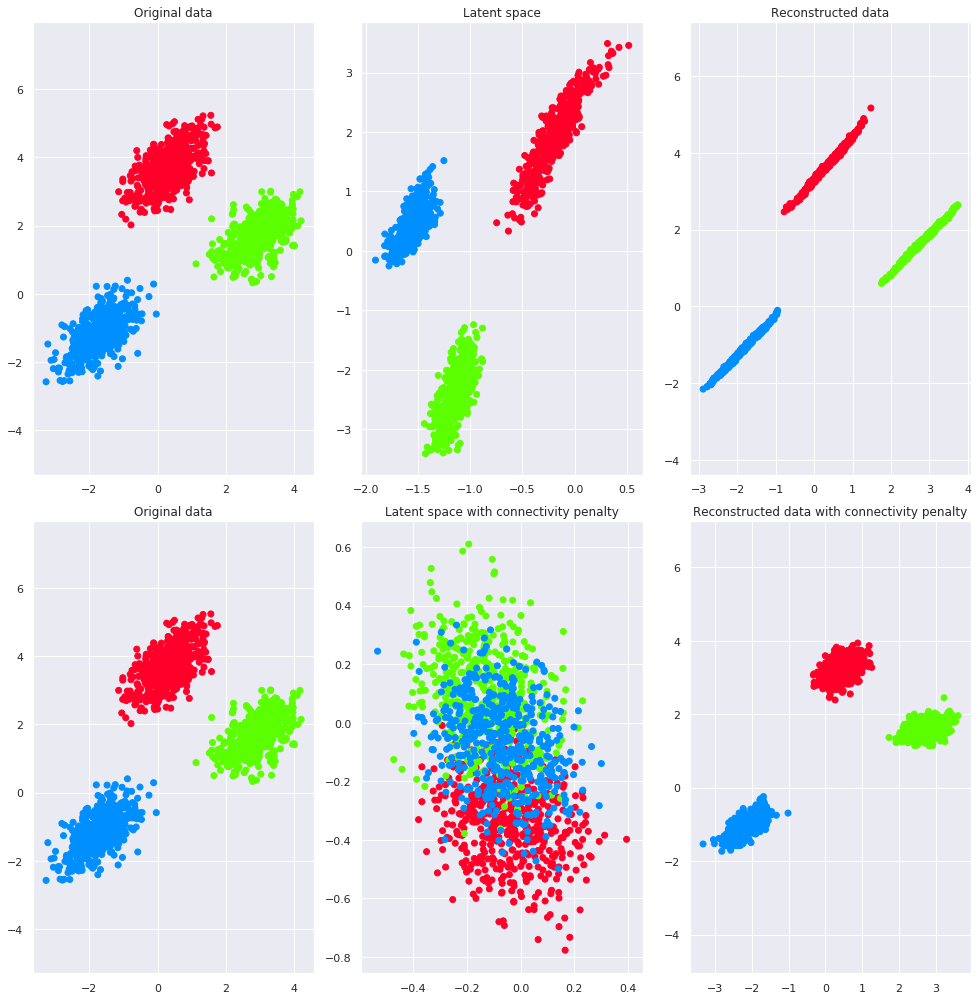

[6.6158905, 7.604873300950634, 64.850586]
[0.76730335, 1.1168341557131838, 38.98906]
[1.3904831, 1.7053672174678953, 2.2262487]


In [6]:
fig, axes = plt.subplots(figsize=(14, 14), nrows=2, ncols=3)

data = data.to(model_no_penalty.device)
data_plot = data.cpu().data

ax = axes[0, 0]
ax.scatter(data_plot[:, 0], data_plot[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_aspect('equal', 'datalim')
ax.set_title('Original data')

ax = axes[0, 1]
latent_space_no_penalty = model_no_penalty.autoencoder.encoder(data).cpu().data
ax.scatter(latent_space_no_penalty[:, 0], latent_space_no_penalty[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_title('Latent space')

ax = axes[0, 2]
reconstructed_data = model_no_penalty.autoencoder(data).cpu().data
ax.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_aspect('equal', 'datalim')
ax.set_title('Reconstructed data')


ax = axes[1, 0]
ax.scatter(data_plot[:, 0], data_plot[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_aspect('equal', 'datalim')
ax.set_title('Original data')

ax = axes[1, 1]
latent_space_penalty = model_penalty.autoencoder.encoder(data).cpu().data
ax.scatter(latent_space_penalty[:, 0], latent_space_penalty[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_title('Latent space with connectivity penalty')

ax = axes[1, 2]
reconstructed_data = model_penalty.autoencoder(data).cpu().data
ax.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_aspect('equal', 'datalim')
ax.set_title('Reconstructed data with connectivity penalty')

plt.tight_layout()
plt.show()

print(barcode_stats(data))
print(barcode_stats(latent_space_no_penalty))
print(barcode_stats(latent_space_penalty))